## Train Sample Model

tensorflow==2.10.1 and transformers==4.26.1

The purpose of this notebook is to assemble a dataset using the cleaned dataset csvs created in our preprocessing step and then fine-tune GPT-2 onto conversations of interest.

In [1]:
import tensorflow as tf
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling
from transformers import create_optimizer

In [22]:
folder = "clean_dataset"

lines = pd.read_csv(f"{folder}/movie_lines.csv")
convos = pd.read_csv(f"{folder}/movie_conversations.csv")
char_meta = pd.read_csv(f"{folder}/movie_characters_metadata.csv")
title_meta = pd.read_csv(f"{folder}/movie_titles_metadata.csv")

all_data = pd.read_csv(f"{folder}/movie_all_data.csv")

print("-----LINES-----")
display(lines.head())

print("-----CONVOS-----")
display(convos.head())

print("-----CHARACTER META-----")
display(char_meta.head())

print("-----TITLE META-----")
display(title_meta.head())

print("-----MOVIE ALL DATA-----")
display(all_data.head())

-----LINES-----


,line_id,character_id,movie_id,character_name,line_text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


-----CONVOS-----


,character_id1_conv,character_id2_conv,movie_id,line_order_conv
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


-----CHARACTER META-----


,character_id,character_name,movie_id,movie_name,gender,position_credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


-----TITLE META-----


,movie_id,movie_title,movie_year,IMDB_rating,IMDB_votes,genres
0,m0,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.2,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.1,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.4,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.9,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."


-----MOVIE ALL DATA-----


,character_id,character_name,movie_id,movie_name,gender,position_credits,movie_year,IMDB_rating,IMDB_votes,genres,line_id,line_text
0,u0,BIANCA,m0,10 things i hate about you,f,4,1999,6.9,62847,"['comedy', 'romance']",L1045,They do not!
1,u0,BIANCA,m0,10 things i hate about you,f,4,1999,6.9,62847,"['comedy', 'romance']",L985,I hope so.
2,u0,BIANCA,m0,10 things i hate about you,f,4,1999,6.9,62847,"['comedy', 'romance']",L925,Let's go.
3,u0,BIANCA,m0,10 things i hate about you,f,4,1999,6.9,62847,"['comedy', 'romance']",L872,Okay -- you're gonna need to learn how to lie.
4,u0,BIANCA,m0,10 things i hate about you,f,4,1999,6.9,62847,"['comedy', 'romance']",L870,I'm kidding. You know how sometimes you just ...


## Assemble Dataset

Form a dataset of movie-lines from conversations including a set of favorable characters from a certain genre of movies.

In [3]:
character_gender = "m"
movie_category = "romance"

char_id_list = char_meta["character_id"].loc[char_meta["gender"] == character_gender]
movie_list = title_meta["movie_id"].loc[title_meta["genres"].apply(lambda genres: movie_category in genres)]

# Grab conversations from both movie list and character id list
conversations_df = convos.loc[
    ((convos["character_id1_conv"].isin(char_id_list)) | (convos["character_id2_conv"].isin(char_id_list))) & 
    (convos["movie_id"].isin(movie_list))]

# Convert the string representations of lists into actual lists
conversations_df["line_order_conv"] = conversations_df["line_order_conv"].apply(ast.literal_eval)
line_id_list = [line_id for sublist in conversations_df["line_order_conv"] for line_id in sublist]

# Create movie lines dataset
final_movie_lines = lines.loc[lines["line_id"].isin(line_id_list)]
final_movie_lines = final_movie_lines[final_movie_lines['line_text'].apply(lambda x: isinstance(x, str))]

# Group Dialogues according to conversation
grouped_dialogues = []

for line_ids in conversations_df["line_order_conv"]:
    # Collect the lines that belong to the current conversation
    conversation_lines = final_movie_lines.loc[final_movie_lines["line_id"].isin(line_ids), "line_text"].tolist()
    grouped_dialogue = " ".join(conversation_lines).strip()
    grouped_dialogues.append(grouped_dialogue)

print(f"Number of {character_gender} characters: ", len(char_id_list))
print(f"Number of {movie_category} movies: ", len(movie_list))
print("Number of conversations: ", len(conversations_df))
print("Number of movie lines: ", len(line_id_list))
print("Number of grouped dialogues: ", len(grouped_dialogues))

display(conversations_df.head())
display(final_movie_lines.head())

print(grouped_dialogues[0])

ungrouped_dialogues = list(final_movie_lines['line_text'])
print(ungrouped_dialogues[0])

dataset_dialogue = grouped_dialogues # More thorough examples

C:\Users\Philip Felizarta\AppData\Local\Temp\ipykernel_16064\3873860020.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversations_df["line_order_conv"] = conversations_df["line_order_conv"].apply(ast.literal_eval)


Number of m characters:  1899
Number of romance movies:  132
Number of conversations:  16012
Number of movie lines:  62277
Number of grouped dialogues:  16012


,character_id1_conv,character_id2_conv,movie_id,line_order_conv
0,u0,u2,m0,"[L194, L195, L196, L197]"
1,u0,u2,m0,"[L198, L199]"
2,u0,u2,m0,"[L200, L201, L202, L203]"
3,u0,u2,m0,"[L204, L205, L206]"
4,u0,u2,m0,"[L207, L208]"


,line_id,character_id,movie_id,character_name,line_text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


Okay... then how 'bout we try out some French cuisine.  Saturday?  Night? Not the hacking and gagging and spitting part.  Please. Well, I thought we'd start with pronunciation, if that's okay with you. Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
They do not!


### Use Pretrained Model Tokenizer

In [4]:
MAX_TOKENS = 128

# Prepare Hugging Face Dataset
dialogue_dataset = Dataset.from_dict({"text": dataset_dialogue})

# Tokenize the data using GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'  # Set left-padding for decoder-only models

example_text = dataset_dialogue[0]
tokenized_example = tokenizer(example_text, padding="max_length", truncation=True, max_length=MAX_TOKENS)

# Print out the results
print("Original Text:", example_text)
print("Tokenized input_ids:", tokenized_example["input_ids"])
print("Tokenized attention_mask:", tokenized_example["attention_mask"])

decoded_text = tokenizer.decode(tokenized_example["input_ids"], skip_special_tokens=True)
print("\nDecoded text from token_ids:\n", decoded_text)

Z:\MiniConda\envs\tf\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Original Text: Okay... then how 'bout we try out some French cuisine.  Saturday?  Night? Not the hacking and gagging and spitting part.  Please. Well, I thought we'd start with pronunciation, if that's okay with you. Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Tokenized input_ids: [50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 16454, 986, 788, 703, 705, 65, 448, 356, 1949, 503, 617, 4141, 33072, 13, 220, 3909, 30, 220, 5265, 30, 1892, 262, 15656, 290, 308, 16406, 290, 46266, 636, 13, 220, 4222, 13, 3894, 11, 314, 1807, 356, 1549, 923, 351, 41694, 11, 611, 326, 338, 8788, 351, 345, 13, 1680, 356, 787, 428, 2068, 3

### Create next token prediction dataset

This block of code assembles a tensorflow dataset with the inputs as a series of tokens and the output as the next token in the sentence. This truncates lines of text if they exceed 60 tokens.

The optimizer used by default in the Hugging Face Library is an AdamW model. Since we are fine tuning, our group utilied a small learning rate (5e-5) to train GPT2 on this dataset.

In [10]:
# Tokenize the dialogues
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_TOKENS)

tokenized_datasets = dialogue_dataset.map(tokenize_function, batched=True, num_proc=1, remove_columns=["text"])

# Train Test Split
train_test_split = tokenized_datasets.train_test_split(test_size=0.01)  # 1% for validation
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Convert to TensorFlow Dataset
def to_tf_dataset(tokenized_dataset, batch_size):
    return tokenized_dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["input_ids"],  # This specifies that the labels are the input_ids
        shuffle=True,
        batch_size=batch_size,
        collate_fn=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

# Batch size
batch_size = 16

train_dataset_tf = to_tf_dataset(train_dataset, batch_size=batch_size)
val_dataset_tf = to_tf_dataset(val_dataset, batch_size=batch_size)

# Get a single example from the first batch and print it for sanity checking.
for batch in train_dataset_tf.take(1):
    inputs, labels = batch  # Unpack the tuple into inputs and labels

    input_ids_batch = inputs['input_ids'].numpy()  
    attention_mask_batch = inputs['attention_mask'].numpy()  
    labels_batch = labels.numpy()  # Access the labels

    print("Input IDs Batch:", input_ids_batch[0])
    print("Labels Batch:", labels_batch[0])
    print("Attention Mask Batch:", attention_mask_batch[0])
    
    break  

Map:   0%|          | 0/16012 [00:00<?, ? examples/s]

Input IDs Batch: [50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256   464 44348   338
   257 10285    13   220  1400  3002    13   220  1400  5288    13   843
   484  1660   511 11758    13   632   338 14084   329   262 31863 14093
  4315    13  3619    11   345   351   514    30]
Labels Batch: [50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 

## Model Training

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


991/991 [==============================] - 250s 236ms/step - loss: 3.9878 - val_loss: 0.8983
Model fine-tuning complete!


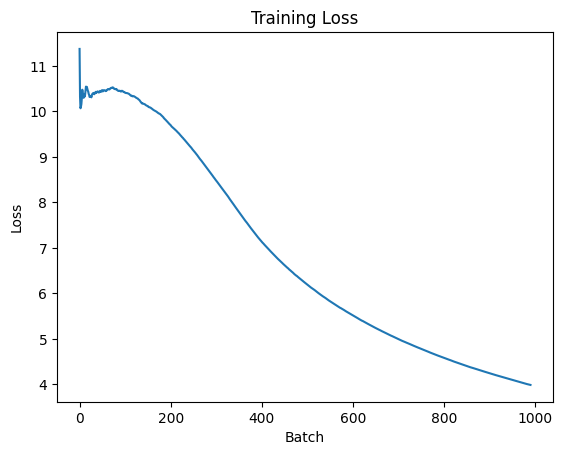

In [18]:
# Track batchwise loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
    
    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))
        

EPOCHS = 1
# Load the Pre-trained GPT-2 Model
model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Compile the model
num_train_steps = int(len(train_dataset) * EPOCHS)
optimizer, lr_schedule = create_optimizer(init_lr=1e-6, num_warmup_steps=800, num_train_steps=num_train_steps)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn)

loss_history = LossHistory()
history = model.fit(train_dataset_tf,
                    epochs=EPOCHS,
                    validation_data=val_dataset_tf,
                    callbacks=[loss_history])

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_model_tf")
tokenizer.save_pretrained("./fine_tuned_model_tf")

print("Model fine-tuning complete!")

plt.plot(loss_history.losses)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

### Example Inference

In [19]:
def get_fine_tuned():
    model = TFGPT2LMHeadModel.from_pretrained("./fine_tuned_model_tf")
    tokenizer = GPT2Tokenizer.from_pretrained("./fine_tuned_model_tf")
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'  # Set left-padding for decoder-only models

    return model, tokenizer

def get_standard():
    model = TFGPT2LMHeadModel.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'  # Set left-padding for decoder-only models

    return model, tokenizer

def model_infer(prompt, model, tokenizer):
    # Tokenize the input and create attention mask
    inputs = tokenizer(prompt, padding="max_length", 
                       truncation=True, 
                       max_length=MAX_TOKENS, 
                       return_tensors="tf")
    
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    # Set pad_token_id explicitly to eos_token
    generated_output = model.generate(
        input_ids,
        attention_mask=attention_mask,  # Pass attention mask to handle padding properly
        max_new_tokens=MAX_TOKENS,  # Increase length to allow more fluid continuation
        num_return_sequences=1,  # Generate number of sequences
        no_repeat_ngram_size=1,  # No repetition for natural flow
        do_sample=True,  # Enable sampling
        top_k=50,  # Allows selection only from top_k,
        top_p=0.92,  # Tightens the probability distribution for less randomness
        temperature=0.7,  # Lower temperature for more deterministic responses
        pad_token_id=tokenizer.eos_token_id  # Set pad_token to eos_token explicitly
    )
    
    # Decode the generated output
    generated_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    
    return generated_text
    
fine_model, fine_tokenizer = get_fine_tuned()
standard_model, standard_tokenizer = get_standard()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./fine_tuned_model_tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [20]:
prompt = "Why do you have to leave?"
model_output = model_infer(prompt, fine_model, fine_tokenizer)
print(f"Fine Tuned Model Output:\n {model_output}")

model_output = model_infer(prompt, standard_model, standard_tokenizer)
print(f"Standard Model Output:\n {model_output}")

Fine Tuned Model Output:
 Why do you have to leave?
The answer is no. You can't stay at the hotel or take a taxi in your car, but it's safe and easy if there are cars on duty that want help with their luggage while they go back home from work tomorrow evening for lunch; therefore this option has been given by our drivers who choose alternative route than taxis which offer better service such as bus hire company (BHV) B H V I M L W S. But because of inconvenience due people might not like taking buses till after 11:00 so please don´t try again today afternoon especially when busy morning time means much more convenient way then getting into hotels
Standard Model Output:
 Why do you have to leave?
I want them all right now. I'm going out and getting ready for a few weeks of playing football."

, who is known as "The King" on Twitter. He was born in Toronto but raised here with his wife Annabelle (born July 18th 1997), two sons Roberta & James B., six daughters Sarah Lynn Mowbray McLeod F